# Plot Path

Given an ordered set of cells, produces downstream visualizations. To be used in conjunction with Paga.ipynb and operates on outputs of that notebook. Refer to PAGA graph for paths.

In [60]:
library(reshape2)
library(viridis)
library(scales)
library(ggplot2)
library(ClusterR)
library(RColorBrewer)
library(Matrix)
library(GenomicRanges)
library(rtracklayer)

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

In [3]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

## Load Data

In [4]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 409052

In [5]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 409052      4

chr  bp1   bp2   site_name       
chr1_10355_10867 chr1 10355 10867 chr1_10355_10867
chr1_41995_42521 chr1 41995 42521 chr1_41995_42521
chr1_46067_46593 chr1 46067 46593 chr1_46067_46593
chr1_48475_48975 chr1 48475 48975 chr1_48475_48975
chr1_51286_52235 chr1 51286 52235 chr1_51286_52235
chr1_58648_59148 chr1 58648 59148 chr1_58648_59148

In [6]:
peaks_gr = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))
peaks_gr

GRanges object with 409052 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       10355-10867      *
       [2]     chr1       41995-42521      *
       [3]     chr1       46067-46593      *
       [4]     chr1       48475-48975      *
       [5]     chr1       51286-52235      *
       ...      ...               ...    ...
  [409048]     chrY 24527581-24528081      *
  [409049]     chrY 25399027-25399550      *
  [409050]     chrY 26315001-26315511      *
  [409051]     chrY 26409272-26409772      *
  [409052]     chrY 26670852-26671639      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [7]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [8]:
pmatRowSums = Matrix::rowSums(pmat)

In [9]:
pmatColSums = Matrix::colSums(pmat)

In [10]:
min(pmatRowSums)

[1] 310

In [11]:
min(pmatColSums)

[1] 31

In [12]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 68916     5

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
                    cells              
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA

### Load Pseudotime Data

In [13]:
# Metadata file from previous Paga run
# should contain same cells as those in `pmat_metaData`
# there may be a version mismatch

# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster, pseudotime coordinates
pt_metaData = read.table("./sessions/20200223_n74838/metadata.tsv", header = T)
pt_metaData$barcode = lapply(strsplit(rownames(pt_metaData), '_'), "[[", 2)
pt_metaData = pt_metaData[order(rownames(pt_metaData)), ]
head(pt_metaData, 2)

sample umap.1   umap.2    cluster dpt_pseudotime
D0_AAACAACGACGATTAC D0     6.545686 -7.701751 2       0.00000000    
D0_AAACAACGACTCACGG D0     5.180663 -7.633298 2       0.03794836    
                    barcode         
D0_AAACAACGACGATTAC AAACAACGACGATTAC
D0_AAACAACGACTCACGG AAACAACGACTCACGG

In [14]:
# resolve mismatch
dim(metaData)
dim(pt_metaData)
cells_intersect = intersect(rownames(metaData), rownames(pt_metaData))
length(cells_intersect)

[1] 68916     5

[1] 74838     6

[1] 67067

In [15]:
metaData_subset = metaData[rownames(metaData) %in% cells_intersect, ]
pmat_subset = pmat[rownames(metaData) %in% cells_intersect, ]

In [16]:
# copy over cluster and pseudotime from pt_metaData
# NB: may have to change this when pseudotime runs are updated
metaData_subset$cluster = pt_metaData[rownames(metaData_subset), "cluster"]
metaData_subset$dpt_pseudotime = pt_metaData[rownames(metaData_subset), "dpt_pseudotime"]
head(metaData_subset)

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
D0_AAACACGCTCGAGTGA AAACACGCTCGAGTGA D0     3.408866 -9.058377
                    cells               cluster dpt_pseudotime
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC 2       0.00000000    
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT 2       0.02919693    
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC 2       0.03123864    
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG 2       0.05292678    
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA 2       0.02582447    
D0_AAACACGCTCGAGTGA D0_AAACACGCTCGAGTGA 1       0.12396142

In [17]:
dim(metaData_subset)
dim(pmat_subset)

[1] 67067     7

[1]  67067 409052

In [18]:
pmat = pmat_subset
metaData = metaData_subset

### Load ChromVar

In [285]:
# Load ChromVAR
chromvar = read.table(gzfile("../20200607_ChromVAR/out/20200520_n68916/20200803_BPNet_hits.tsv"), 
                      sep='\t')
all(rownames(metaData) %in% rownames(chromvar))
chromvar = chromvar[rownames(metaData),]
head(chromvar)

[1] TRUE

AP.1.bZIP. AP.2alpha.AP2. AP.2gamma.AP2. Ap4.bHLH. 
D0_AAACAACGACGATTAC 0.06062397 -0.19032848    -0.1806503     0.17649547
D0_AAACAACGAGCGCACT 0.12663771 -0.14932617    -0.1460632     0.13774811
D0_AAACACGCTACGCCAC 0.09179008 -0.27554985    -0.2684003     0.08156974
D0_AAACACGCTAGTACGG 0.22381185 -0.26024118    -0.2036954     0.19888174
D0_AAACACGCTCCTCAAA 0.09114996  0.03742272     0.0294599     0.51376057
D0_AAACACGCTCGAGTGA 0.27790548 -0.16897421    -0.1574511     0.02599568
                    Ascl2.bHLH. Atf1.bZIP. Atf2.bZIP. Atf3.bZIP. Atf4.bZIP. 
D0_AAACAACGACGATTAC  0.20330932 0.19744625 0.2751513  0.06082699  0.18974676
D0_AAACAACGAGCGCACT  0.08177252 0.09700864 0.2162815  0.12902809  0.16677545
D0_AAACACGCTACGCCAC  0.05768925 0.03807517 0.1018324  0.09991380 -0.06845765
D0_AAACACGCTAGTACGG  0.10450553 0.31782572 0.3421748  0.21633007  0.10552211
D0_AAACACGCTCCTCAAA  0.47133141 0.25353973 0.3047178  0.09847050  0.22350682
D0_AAACACGCTCGAGTGA -0.03327538 0.17291435 0.2474830  0.27188456  0.18969270
                    Atf7.bZIP. ⋯ TEAD3.TEA.   TEAD4.TEA.   Tlx..NR.   
D0_AAACAACGACGATTAC 0.25606442 ⋯  0.002451155  0.025287838  0.03428715
D0_AAACAACGAGCGCACT 0.11791373 ⋯ -0.179139154 -0.151820849  0.06055087
D0_AAACACGCTACGCCAC 0.08080772 ⋯  0.079465507  0.020082845 -0.05890462
D0_AAACACGCTAGTACGG 0.31998972 ⋯ -0.019393802  0.000957712 -0.08016259
D0_AAACACGCTCCTCAAA 0.26436031 ⋯  0.095798814  0.133782422  0.16927521
D0_AAACACGCTCGAGTGA 0.21165326 ⋯  0.071669620  0.092258454  0.08502060
                    WT1.Zf.     X.box.HTH.  YY1.Zf.      ZBTB18.Zf.
D0_AAACAACGACGATTAC -0.06157709  0.03630303  0.124991304  0.2653416
D0_AAACAACGAGCGCACT -0.13966197  0.22376462  0.138647337  0.2073126
D0_AAACACGCTACGCCAC -0.07673906 -0.01883431  0.003362537  0.1058641
D0_AAACACGCTAGTACGG -0.14234028  0.07883517  0.081795776  0.1828109
D0_AAACACGCTCCTCAAA  0.15624446  0.26249340  0.249567353  0.3349750
D0_AAACACGCTCGAGTGA -0.04936458 -0.06085424 -0.138721761 -0.0602405
                    ZBTB33.Zf.    Zic3.Zf.     ZNF143.STAF.Zf.
D0_AAACAACGACGATTAC  5.275922e-02 -0.001890931 -0.02174877    
D0_AAACAACGAGCGCACT -1.104272e-01 -0.065519777 -0.07611443    
D0_AAACACGCTACGCCAC  2.377935e-02  0.086366377 -0.06923392    
D0_AAACACGCTAGTACGG  1.008728e-02 -0.023485845  0.05765025    
D0_AAACACGCTCCTCAAA -1.091846e-01  0.064166909 -0.26921093    
D0_AAACACGCTCGAGTGA -5.107868e-05 -0.027740995 -0.06831649

### Gene Set

In [61]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gencode.basic.tx.hg38 = subset(subset(gencode.basic.hg38, gene_type=="protein_coding"), type=="transcript")
head(gencode.basic.tx.hg38, 3)
length(gencode.basic.tx.hg38)

Warning message in readGFF(filepath, version = version, filter = filter):
“connection is not positioned at the start of the file, rewinding it”


GRanges object with 3 ranges and 21 metadata columns:
      seqnames        ranges strand |   source       type     score     phase
         <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1   65419-71585      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1   69055-70108      + |  ENSEMBL transcript      <NA>      <NA>
  [3]     chr1 450703-451697      - |   HAVANA transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
  [3] ENSG00000284733.1 protein_coding      OR4F29           2  HGNC:31275
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 

[1] 58073

In [62]:
tx.hg38 = gencode.basic.tx.hg38

In [63]:
tss.hg38 = unique(resize(tx.hg38, width=1, fix='start'))

In [64]:
prom.hg38 = promoters(tss.hg38, upstream = 100, downstream = 100)
head(prom.hg38, 2)

GRanges object with 2 ranges and 21 metadata columns:
      seqnames      ranges strand |   source       type     score     phase
         <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1 65319-65518      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1 68955-69154      + |  ENSEMBL transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 ENST00000641515.2  protein_coding       OR4F5-202
  [2] OTTHUMG00000001094.4 ENST00000335137.4  protein_coding       OR4F5-201
      transcript_support_level    

In [65]:
unique_prom_genes = names(table(prom.hg38$gene_name)[which(table(prom.hg38$gene_name)==1)])

### Checks

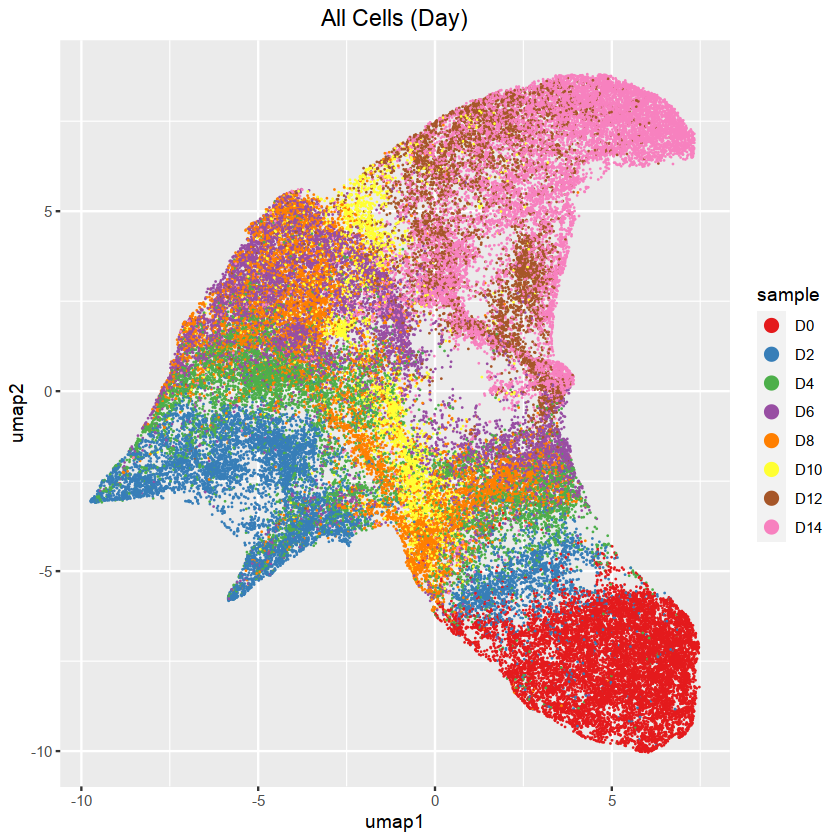

In [19]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                sample=metaData$sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.5, alpha=1, stroke=0, aes(x=umap1 , y=umap2, col=sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

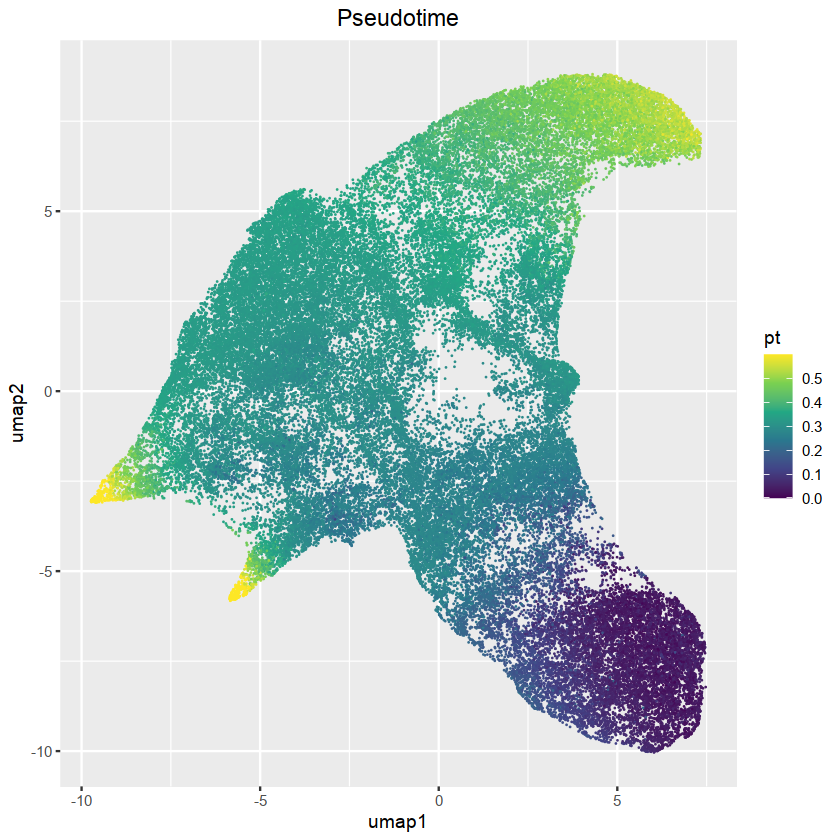

In [20]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2, 
                pt=metaData$dpt_pseudotime)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap1, y=umap2, col=pt)) +
geom_point(size=0.5, alpha=1, stroke=0) +
scale_color_viridis_c(limits=c(0,0.6), oob=squish) +
ggtitle("Pseudotime") + 
theme(plot.title = element_text(hjust = 0.5))

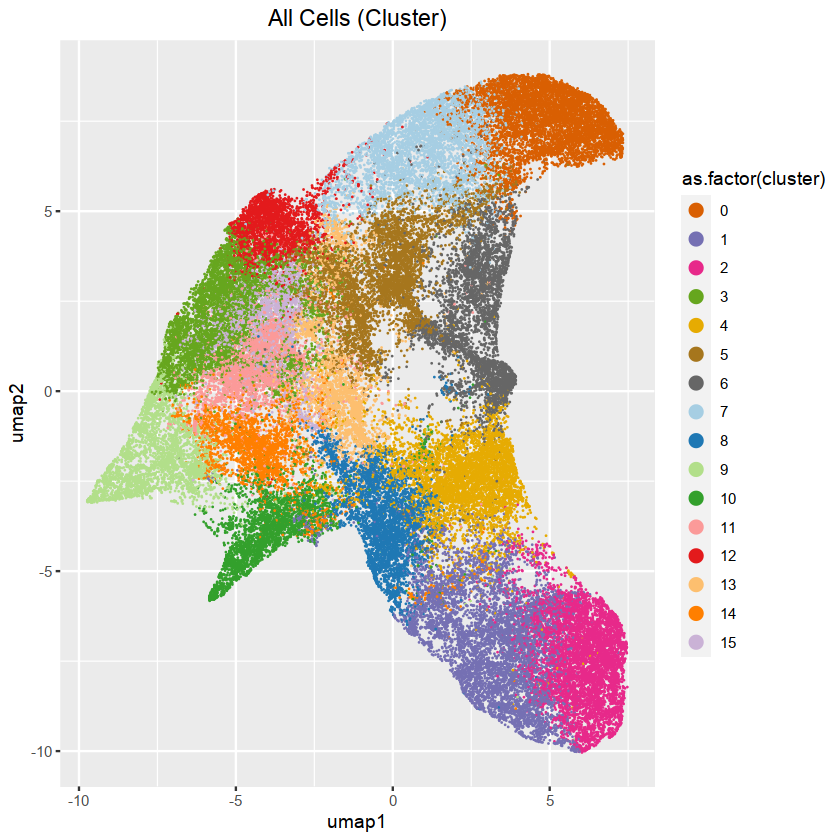

In [21]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                cluster=metaData$cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap1, y=umap2, col=as.factor(cluster))) +
geom_point(size=0.5, alpha=1, stroke=0) +
scale_colour_manual(values = col_vector[seq(10,67)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [53]:
table(metaData$sample[metaData$cluster=="13"])


  D0   D2   D4   D6   D8  D10  D12  D14 
   0   11  459  235  493 1362   35   85 

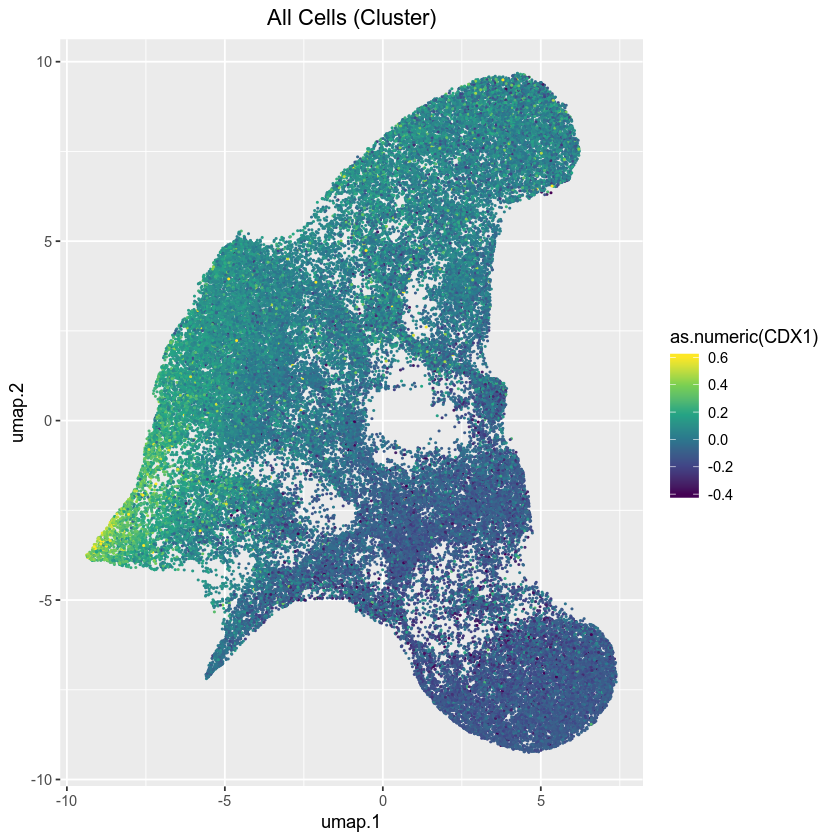

In [38]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@cluster, chromvar[,5:ncol(chromvar)])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=as.numeric(CDX1))) +
geom_point(size=0.2, alpha=1) +
scale_color_viridis_c(limits=c(-0.4,0.6), oob=squish) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) 

## Plot a Path

In [22]:
clusters_in_path = c(2, 1, 14, 13, 15,11, 3, 12, 7, 0)
# clusters_in_path = c(14, 13, 15,11, 3)
# clusters_in_path = c(2, 1, 10)
# clusters_in_path = c(2, 1, 14, 9)

In [23]:
cells_in_path = metaData[metaData$cluster %in% clusters_in_path, ]
cells_in_path = cells_in_path[order(cells_in_path$dpt_pseudotime), ]
dim(cells_in_path)

[1] 42032     7

In [24]:
SUBSAMPLE_TO = 30000

cells_in_path = cells_in_path[sort(sample(nrow(cells_in_path), SUBSAMPLE_TO)), ]
dim(cells_in_path)

[1] 30000     7

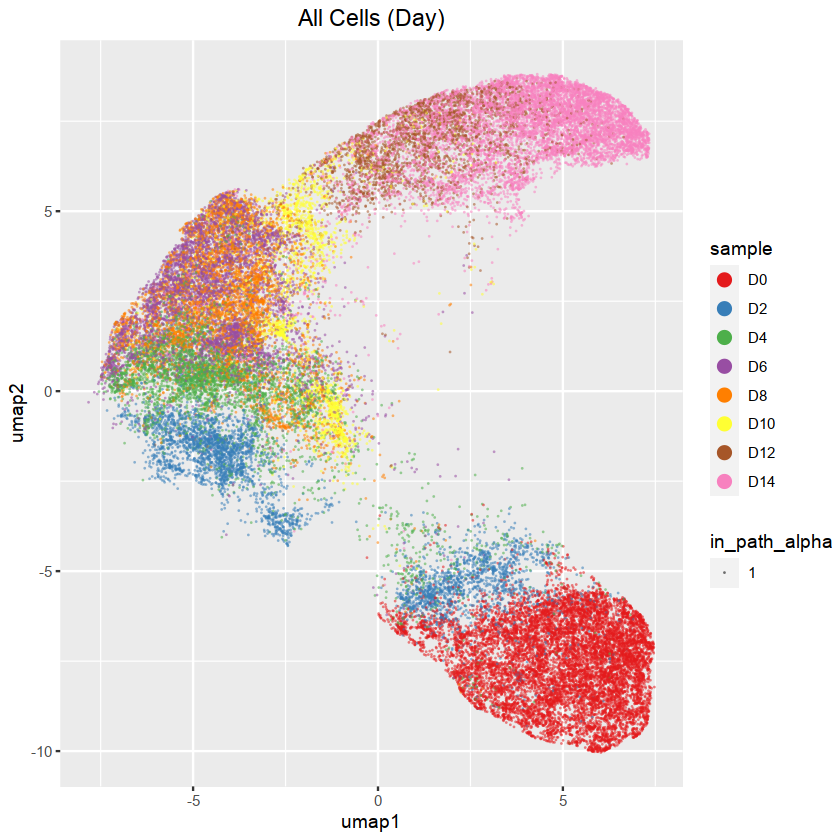

In [25]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2, 
                sample=metaData$sample, 
                in_path_alpha=ifelse(metaData$cluster %in% clusters_in_path, 1, 0))

# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df[df$in_path_alpha==1,]) +
geom_point(size=0.5, stroke=0, aes(x=umap1 , y=umap2, col=sample, alpha=in_path_alpha)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

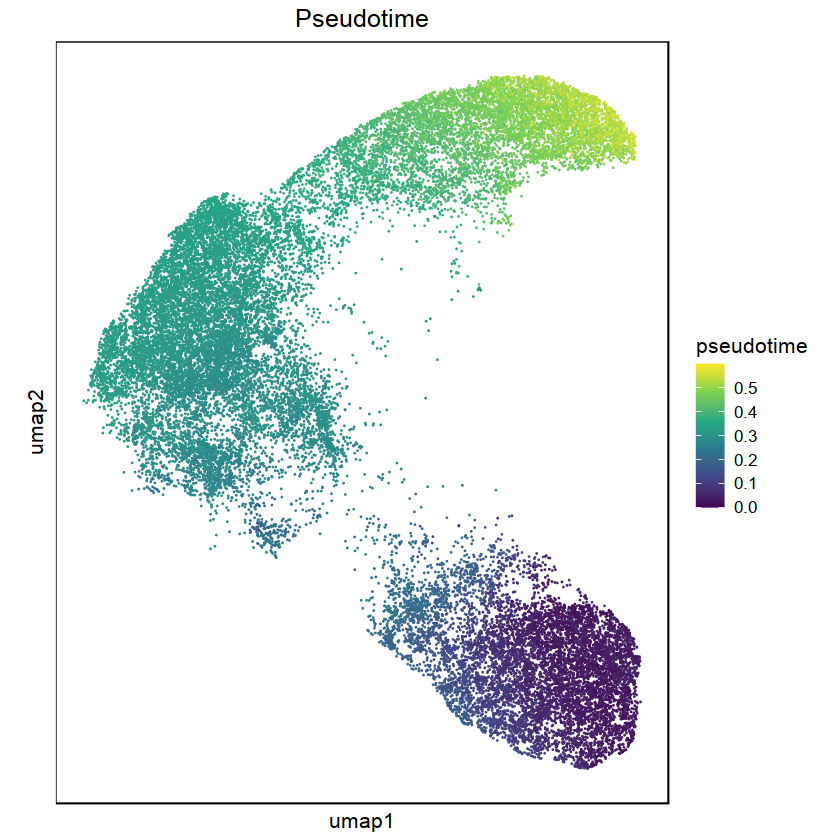

In [242]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(cells_in_path[,c("umap1", "umap2")], pt=cells_in_path$dpt_pseudotime)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap1, y=umap2, col=pt)) +
geom_point(size=0.5, stroke=0, alpha=1) +
scale_color_viridis_c(limits=c(0,0.6), 
                      oob=squish,
                     name="pseudotime") +
ggtitle("Pseudotime") + 
theme_classic() +
theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()

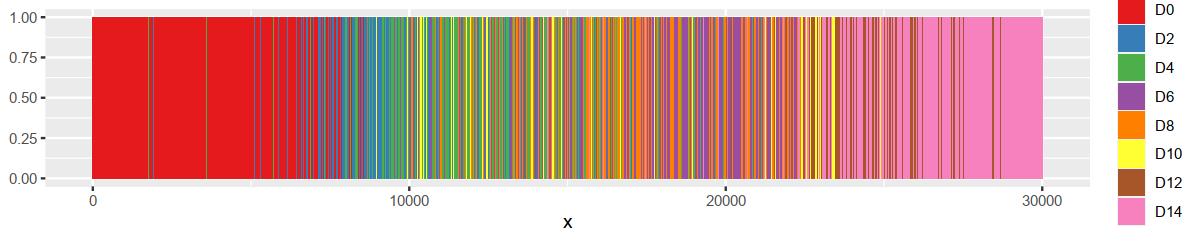

In [27]:
options(repr.plot.width = 10, repr.plot.height = 2)

cur_df = data.frame(x=seq(1,nrow(cells_in_path)),
                    d=factor(cells_in_path$sample,
                            levels=DAYS))
ggplot(cur_df) +
geom_col(aes(x=x, y=1, fill=d),  width=1) +
scale_fill_brewer(breaks=DAYS, palette = "Set1") +
ylab(NULL)

## Plot ChromVAR

In [460]:
motif_df = t(chromvar[rownames(cells_in_path),5:ncol(chromvar)])

# remove NAs
motif_df = motif_df[, colSums(is.na(motif_df))==0]

head(motif_df)
dim(motif_df)

D0_GTCTCGTACCGCAAAG D0_GGGCTTCGATACGATC D0_TCCGAGTCTCATACTG
Ascl2.bHLH. 0.1163027           0.15893301           0.14148308        
Atf1.bZIP.  0.1722735           0.11848177           0.08919151        
Atf2.bZIP.  0.2616254           0.17029550           0.10667347        
Atf3.bZIP.  0.1637289           0.08946744           0.07523386        
Atf4.bZIP.  0.1500512           0.32542285          -0.01237039        
Atf7.bZIP.  0.2087589           0.16568581           0.06542385        
            D0_TGCCTACTGACAACAA D0_AAACATGGAGTACACT D0_GCCGAACTGCACCTAA
Ascl2.bHLH. 0.16013049          0.002210312         0.1507486          
Atf1.bZIP.  0.17119215          0.109916018         0.1984954          
Atf2.bZIP.  0.20050104          0.263153548         0.2565332          
Atf3.bZIP.  0.08016137          0.151340916         0.1644267          
Atf4.bZIP.  0.25543924          0.259563629         0.3721130          
Atf7.bZIP.  0.19059329          0.254088411         0.2582861          
            D0_GGTTCAATGTCTGTAG D0_CCAGCACGACATTCAG D0_CAGACTCCTGCGTATT
Ascl2.bHLH. 0.03530688          0.08832444          0.08446628         
Atf1.bZIP.  0.15981007          0.12002448          0.17503175         
Atf2.bZIP.  0.19218416          0.05656460          0.16821514         
Atf3.bZIP.  0.08220087          0.12638559          0.08809777         
Atf4.bZIP.  0.41779813          0.27656447          0.28949409         
Atf7.bZIP.  0.15828420          0.06022836          0.16376282         
            D0_ATAGGCGGACCTAGTA ⋯ D14_CCAGGACTGGCGAGTA D14_TGGGTGCACTCCAGCG
Ascl2.bHLH. 0.1615322           ⋯ -0.129372332          0.001884868        
Atf1.bZIP.  0.2521829           ⋯ -0.145428962         -0.080352667        
Atf2.bZIP.  0.2811096           ⋯ -0.086891476         -0.047811895        
Atf3.bZIP.  0.1417737           ⋯ -0.353053935         -0.299694465        
Atf4.bZIP.  0.4389289           ⋯ -0.365434111         -0.236801749        
Atf7.bZIP.  0.2803172           ⋯  0.004664067          0.095385120        
            D14_GGTGTAACTGTTAGTC D14_TCATTGGGAACCTTGA D14_AAGGGCATGGCTGGCT
Ascl2.bHLH. -0.15593990          -0.14989003          -0.111332489        
Atf1.bZIP.  -0.05703755          -0.04095281           0.017646076        
Atf2.bZIP.  -0.04505162           0.03698789          -0.006344387        
Atf3.bZIP.  -0.30705843          -0.35201168          -0.258202176        
Atf4.bZIP.  -0.01588787          -0.39485954          -0.142932972        
Atf7.bZIP.  -0.06859523           0.04814118           0.086708100        
            D14_CCATCTGTGTTCAGTG D14_GTTTCATTGCAGTCCG D14_TAACGAAGAAATGCGG
Ascl2.bHLH. -0.1531442            0.09046579           0.08725824         
Atf1.bZIP.  -0.2162338           -0.23510262          -0.27225682         
Atf2.bZIP.  -0.3953790           -0.06341380          -0.27263195         
Atf3.bZIP.  -0.3014537           -0.24957554          -0.26064781         
Atf4.bZIP.  -0.2389752           -0.33969446          -0.06373838         
Atf7.bZIP.  -0.2884020           -0.20477581          -0.23329463         
            D14_AACGAGGTGAGGTGCA D14_GCACTTCTGTCTGGAT
Ascl2.bHLH. -0.05290923           0.03385104         
Atf1.bZIP.  -0.28300178          -0.15662743         
Atf2.bZIP.  -0.17482217          -0.18917796         
Atf3.bZIP.  -0.30757190          -0.31876969         
Atf4.bZIP.  -0.21217933          -0.07248389         
Atf7.bZIP.  -0.17826641          -0.04587125

[1]   106 28458

In [461]:
# remove redundant motifs
motif_cors = cor(t(motif_df), method='spearman')
motif_cors[upper.tri(motif_cors)] = 0
diag(motif_cors) = 0
motif_df = motif_df[!apply(motif_cors,1,function(x) any(x > 0.95)), ]
dim(motif_df)                           

[1]    74 28458

In [462]:
# z-norm per cell (there seemed to be a trended bias such that most motifs at later days had higher motif scores)
motif_df = scale(motif_df)

# clip quantiles
clip <- function(x){
    quantiles <- quantile( x, c(.05, .95 ) )
    x[ x < quantiles[1] ] <- quantiles[1]
    x[ x > quantiles[2] ] <- quantiles[2]
    x
}

motif_df = t(apply(motif_df, 1, clip))

# scale to 0-1
motif_df = motif_df - apply(motif_df, 1, min)
motif_df = motif_df/apply(motif_df, 1,max)

In [463]:
# smooth
motif_df_smooth = t(apply(motif_df, 1, smooth))
colnames(motif_df_smooth) = colnames(motif_df)
motif_df = motif_df_smooth
dim(motif_df)

[1]    74 28458

In [464]:
TOP = 50

# choose top TOP by variance
row_vars = apply(motif_df, 1, var)
motif_df = motif_df[rev(order(row_vars))[1:TOP], ]

In [465]:
# take subset
# tf_list = c("POU5F1", "SOX2", "KLF4", "ZBTB7B", "CTCF", "YY1", "TFAP2B", 
#                      "BACH2", "JUNB", "FOXC2", "FOXB1", "ATF4", "JUN", "CEBPA")
# motif_df = motif_df[tf_list, ]

In [466]:
# order rows (motifs)
row_distance = dist(t(scale(t(motif_df))))
row_cluster = hclust(row_distance, method="ward")
row_dendrogram = as.dendrogram(row_cluster)
rowInd = rev(order.dendrogram(row_dendrogram))

motif_df_row_ordered = as.matrix(motif_df[rowInd, ])
head(motif_df_row_ordered, 2)

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



D0_GTCTCGTACCGCAAAG D0_GGGCTTCGATACGATC
Rbpj1...              0.1546757           0.1546757          
OCT.OCT.POU.Homeobox. 0.2173688           0.2173688          
                      D0_TCCGAGTCTCATACTG D0_TGCCTACTGACAACAA
Rbpj1...              0.1546757           0.3973702          
OCT.OCT.POU.Homeobox. 0.2173688           0.2173688          
                      D0_AAACATGGAGTACACT D0_GCCGAACTGCACCTAA
Rbpj1...              0.3973702           0.3973702          
OCT.OCT.POU.Homeobox. 0.2173688           0.2348748          
                      D0_GGTTCAATGTCTGTAG D0_CCAGCACGACATTCAG
Rbpj1...              0.3973702           0.1493681          
OCT.OCT.POU.Homeobox. 0.2348748           0.2744385          
                      D0_CAGACTCCTGCGTATT D0_ATAGGCGGACCTAGTA ⋯
Rbpj1...              0.1493681           0.1493681           ⋯
OCT.OCT.POU.Homeobox. 0.2744385           0.2744385           ⋯
                      D14_CCAGGACTGGCGAGTA D14_TGGGTGCACTCCAGCG
Rbpj1...              0.4630240            0.4630240           
OCT.OCT.POU.Homeobox. 0.6311237            0.4000953           
                      D14_GGTGTAACTGTTAGTC D14_TCATTGGGAACCTTGA
Rbpj1...              0.4630240            0.4434377           
OCT.OCT.POU.Homeobox. 0.4000953            0.3645527           
                      D14_AAGGGCATGGCTGGCT D14_CCATCTGTGTTCAGTG
Rbpj1...              0.4434377            0.4434377           
OCT.OCT.POU.Homeobox. 0.3645527            0.3645527           
                      D14_GTTTCATTGCAGTCCG D14_TAACGAAGAAATGCGG
Rbpj1...              0.3797668            0.3772749           
OCT.OCT.POU.Homeobox. 0.4348736            0.4348736           
                      D14_AACGAGGTGAGGTGCA D14_GCACTTCTGTCTGGAT
Rbpj1...              0.1654467            0.0845162           
OCT.OCT.POU.Homeobox. 0.4348736            0.4348736

In [467]:
melted = melt(motif_df_row_ordered[, seq(1,ncol(motif_df_row_ordered), 10)])
melted$Var1 = factor(melted$Var1, levels=rownames(motif_df_row_ordered))
melted$Var2 = factor(melted$Var2, levels=colnames(motif_df_row_ordered))

In [468]:
head(melted, 2)

Var1                  Var2                value    
1 Rbpj1...              D0_GTCTCGTACCGCAAAG 0.1546757
2 OCT.OCT.POU.Homeobox. D0_GTCTCGTACCGCAAAG 0.2173688

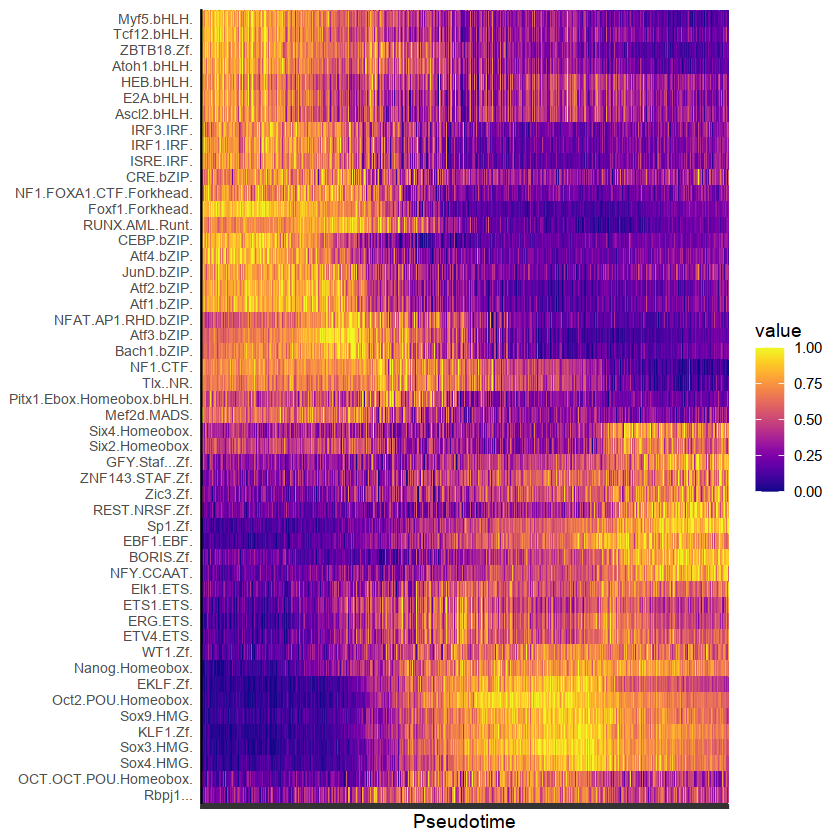

In [469]:
options(repr.plot.width = 7, repr.plot.height = 7)

ggplot(data = melted, mapping = aes(x = Var2,
                                    y = Var1,
                                    fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Pseudotime") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(-1, 1), oob=squish, option = "B") +
# scale_fill_gradient(limits=c(0, 1), oob=squish, low="dodgerblue4", high="khaki1") +
scale_fill_viridis(limits=c(0,1), oob=squish, option='C') +
# facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
theme_classic() +
theme(axis.text.x=element_blank(),
      axis.text.y=element_text(angle=0,hjust=1, size=8),
#       axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
#       panel.spacing.y = unit(0.03, "cm"),
      strip.text.y = element_text(size = 3)) 
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_pluripotency_pseudotime_chromvar.jpeg", format(Sys.Date(), format='%Y%m%d')),
#        width = 15, height = 5, dpi=300)

In [107]:
plot(seq(1,ncol(peak_mat_row_ordered)), peak_mat_row_ordered[1001,]>0)

ERROR: Error in peak_mat_row_ordered[1001, ]: subscript out of bounds


## Pseudotime cluster analysis

### Cluster Cells Along Pseudotime

In [28]:
library(DESeq2)
library(ggrepel)

Loading required package: SummarizedExperiment

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: DelayedArray

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians


Loading required package: BiocParallel


Attaching package: ‘DelayedArray’


The following objects are masked from ‘package:matrixStats’:

    colMaxs, colMins, colRanges, rowMaxs, rowMins, rowRanges


The following objects are masked from ‘package:base’:

    aperm, apply, rowsum




In [29]:
metaData_path = metaData[rownames(metaData) %in% rownames(cells_in_path), ]
pmat_path = pmat[rownames(metaData) %in% rownames(cells_in_path), ]

# sort by pseudotime
pmat_path = pmat_path[order(cells_in_path[rownames(metaData_path), "dpt_pseudotime"]),]
metaData_path = metaData_path[order(cells_in_path[rownames(metaData_path), "dpt_pseudotime"]), ]

# check orders are the same
all(rownames(metaData_path)==rownames(cells_in_path))

[1] TRUE

In [30]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [ ]:
peak_mat = t(pmat_path)
peak_mat_cluster = peak_mat %*% create_sum_matrix(ncol(peak_mat), 100)
rownames(peak_mat_cluster) = as.character(peaks_gr)

In [ ]:
peak_mat_cluster = peak_mat_cluster[rowSums(as.matrix(peak_mat_cluster))>50, ]
dim(peak_mat_cluster)

In [ ]:
sf = estimateSizeFactorsForMatrix(as.matrix(peak_mat_cluster))
norm_cts = t(as.matrix(t(peak_mat_cluster))/sf)

In [ ]:
head(norm_cts, 2)

In [ ]:
log_norm_cts = log2(1+norm_cts)

In [53]:
pca = prcomp(t(log_norm_cts),center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
pcs$clust_num = seq(1,ncol(norm_cts))
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

  [1] 23.42 13.46  1.28  0.96  0.62  0.44  0.41  0.41  0.40  0.39  0.39  0.39
 [13]  0.38  0.38  0.37  0.37  0.36  0.36  0.36  0.36  0.36  0.36  0.35  0.35
 [25]  0.35  0.34  0.34  0.34  0.34  0.34  0.34  0.33  0.33  0.33  0.33  0.33
 [37]  0.32  0.32  0.32  0.32  0.31  0.31  0.31  0.31  0.31  0.31  0.31  0.30
 [49]  0.30  0.30  0.30  0.29  0.29  0.28  0.28  0.28  0.28  0.28  0.28  0.28
 [61]  0.28  0.27  0.27  0.27  0.27  0.27  0.27  0.26  0.26  0.26  0.26  0.26
 [73]  0.25  0.25  0.25  0.25  0.24  0.24  0.24  0.24  0.23  0.23  0.23  0.23
 [85]  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.21  0.21  0.21  0.21
 [97]  0.21  0.21  0.21  0.21  0.21  0.21  0.21  0.21  0.21  0.21  0.21  0.21
[109]  0.21  0.21  0.21  0.20  0.20  0.20  0.20  0.20  0.20  0.20  0.20  0.20
[121]  0.20  0.20  0.20  0.20  0.19  0.19  0.19  0.19  0.19  0.19  0.19  0.19
[133]  0.19  0.19  0.19  0.19  0.19  0.19  0.19  0.19  0.19  0.18  0.18  0.18
[145]  0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.1

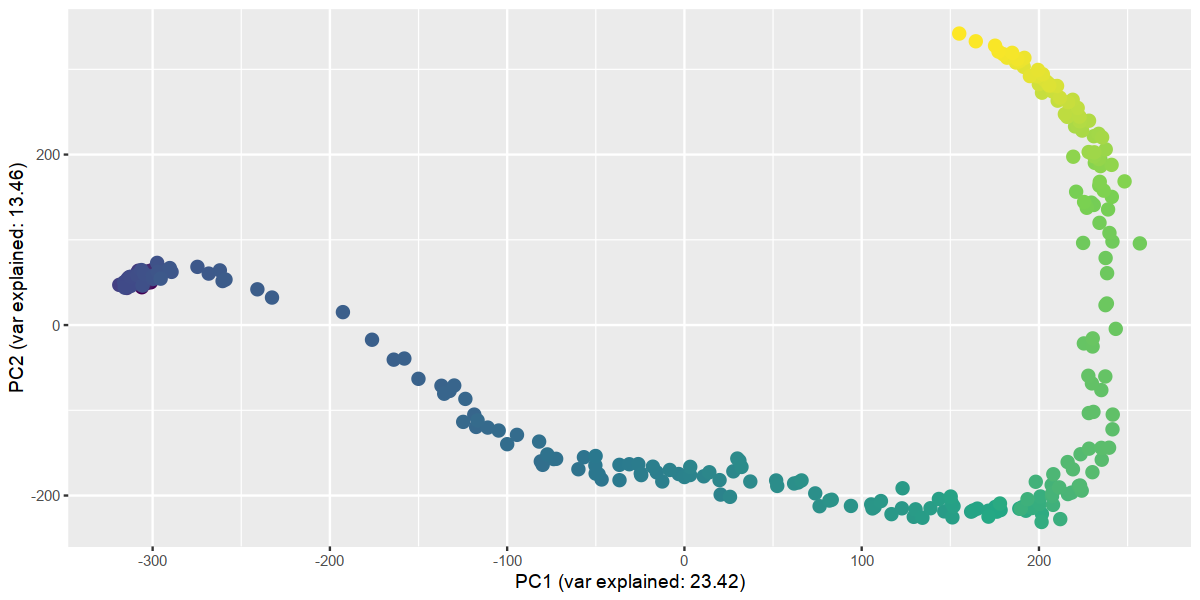

In [480]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(data=pcs,aes(x=PC1,y=PC2,color=clust_num,label=ID))+
geom_point(size=3)+
scale_color_viridis_c() +
# geom_text_repel(size=5, nudge_x = 10)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2])) + 
theme(legend.position="none")

### Gene Scores

In [76]:
cur_regions_gr =  GRanges(rownames(peak_mat_cluster))

In [77]:
tx_with_peak_at_prom = unique(tss.hg38[queryHits(findOverlaps(tss.hg38+100, cur_regions_gr))]$transcript_name)

In [78]:
distal_overlaps = findOverlaps(tss.hg38+100000, cur_regions_gr)
distal_overlaps

Hits object with 1918929 hits and 0 metadata columns:
            queryHits subjectHits
            <integer>   <integer>
        [1]         1           1
        [2]         1           2
        [3]         1           3
        [4]         1           4
        [5]         1           5
        ...       ...         ...
  [1918925]     51887      396866
  [1918926]     51887      396867
  [1918927]     51900      396870
  [1918928]     51917      396873
  [1918929]     51918      396873
  -------
  queryLength: 51948 / subjectLength: 396876

In [84]:
distal_summed_gene = as.matrix(peak_mat_cluster)[subjectHits(distal_overlaps),]

gene_peak_coeff = 1000*(1+abs(mid(cur_regions_gr[subjectHits(distal_overlaps)]) - start(tss.hg38[queryHits(distal_overlaps)])))^(-0.7)

distal_summed_gene = aggregate(gene_peak_coeff * distal_summed_gene, list(queryHits(distal_overlaps)), sum)

# remove transcripts with duplicate entries (e.g. CD99-201 that is on chrY and chrX)
tx_names = prom.hg38[distal_summed_gene$Group.1]$transcript_name
distal_summed_gene = distal_summed_gene[!duplicated(tx_names), ]
rownames(distal_summed_gene) = tx_names[!duplicated(tx_names)]
distal_summed_gene$Group.1 = NULL

# only keep those with a peak at the TSS
distal_summed_gene = distal_summed_gene[rownames(distal_summed_gene) %in% tx_with_peak_at_prom , ]

# DESeq2 normalize
distal_summed_gene = as.data.frame(t(t(distal_summed_gene)/estimateSizeFactorsForMatrix(distal_summed_gene)))

head(distal_summed_gene, 2)

V1       V2       V3       V4       V5       V6       V7      
SAMD11-202 311.7954 275.0580 324.2321 311.1344 327.3730 307.3541 278.9366
SAMD11-213 310.9607 274.4283 323.5040 310.2626 326.5405 306.6270 278.4862
           V8       V9       V10      ⋯ V291     V292     V293     V294    
SAMD11-202 288.4250 276.8938 267.2243 ⋯ 231.9103 178.7403 142.2630 224.8466
SAMD11-213 287.7346 276.3812 266.6215 ⋯ 231.2263 178.3718 141.8466 224.1658
           V295     V296     V297     V298     V299     V300    
SAMD11-202 186.0055 186.6184 141.6437 203.2786 95.70358 116.0878
SAMD11-213 185.4061 186.1506 141.1927 202.4623 95.53858 115.8799

In [109]:
log_tx_score = log2(1+distal_summed_gene)
head(log_tx_score, 2)

V1       V2       V3       V4       V5       V6       V7      
SAMD11-202 8.289076 8.108827 8.345326 8.286024 8.359192 8.268444 8.128956
SAMD11-213 8.285221 8.105533 8.342092 8.281988 8.355529 8.265038 8.126633
           V8       V9       V10      ⋯ V291     V292     V293     V294    
SAMD11-202 8.177046 8.118390 8.067296 ⋯ 7.863630 7.489770 7.162522 7.819200
SAMD11-213 8.173600 8.115726 8.064050 ⋯ 7.859387 7.486809 7.158323 7.814844
           V295     V296     V297     V298     V299     V300    
SAMD11-202 7.546937 7.551658 7.156272 7.674394 6.595497 6.871447
SAMD11-213 7.542305 7.548056 7.151703 7.668618 6.593034 6.868883

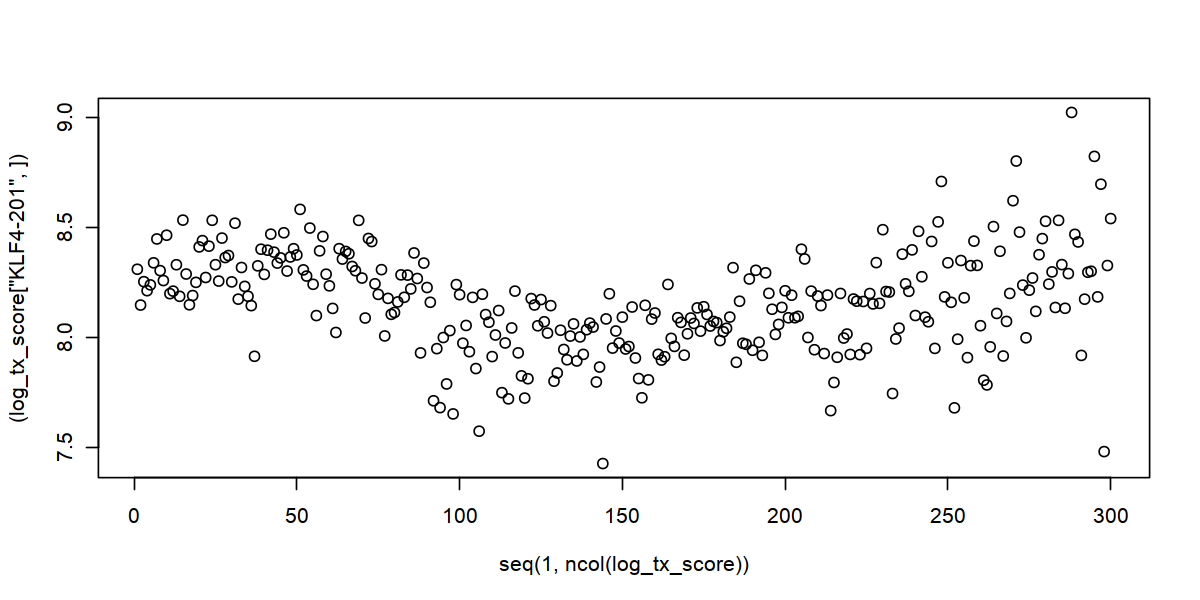

In [103]:
plot(seq(1,ncol(log_tx_score)), (log_tx_score["KLF4-201", ]))

### Gene Score With ChromVAR

In [470]:
colnames(chromvar)[grep("nf1", colnames(chromvar), ignore.case = T)]

[1] "NF1.FOXA1.CTF.Forkhead." "NF1.CTF."               
[3] "ZNF143.STAF.Zf."

In [473]:
rownames(log_tx_score)[grep("^NF1", rownames(log_tx_score))]

[1] "NF1-211" "NF1-204" "NF1-214"

In [474]:
TF = 'NF1.CTF.'
GENE = "NF1-204"

In [475]:
GENE_vals = as.vector(unlist(log_tx_score[GENE, ]))

# clip
# low_cutoff = quantile(GENE_vals, 0.01)
# high_cutoff = quantile(GENE_vals, 0.99)
# GENE_vals[GENE_vals>high_cutoff] = max(GENE_vals)
# GENE_vals[GENE_vals<low_cutoff] = min(GENE_vals)

# min-max norm
GENE_vals = GENE_vals - quantile(smooth(GENE_vals), .01)
GENE_vals = GENE_vals/quantile(smooth(GENE_vals), .99)

In [476]:
TF_vals = chromvar[rownames(cells_in_path), TF]

# average over same cells as GENE_vals
# TF_vals = as.vector(t(TF_vals) %*% create_sum_matrix(ncol(t(TF_vals)), nrow(cells_in_path)/length(GENE_vals)))

# clip
# low_cutoff = quantile(TF_vals, 0.001)
# high_cutoff = quantile(TF_vals, 0.999)
# TF_vals[TF_vals>high_cutoff] = max(TF_vals)
# TF_vals[TF_vals<low_cutoff] = min(TF_vals)

# min-max norm
TF_vals = TF_vals - quantile(smooth(TF_vals), 0.01)
TF_vals = TF_vals/quantile(smooth(TF_vals), 0.99)

In [477]:
TF_df = data.frame(x=seq(1,length(TF_vals)),
                   y=TF_vals, z="TF ChromVAR")
GENE_df = data.frame(x=seq(1,length(TF_vals), length(TF_vals)/length(GENE_vals)),
                     y=GENE_vals, z="Gene Score")
plot_df = rbind(TF_df, GENE_df)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



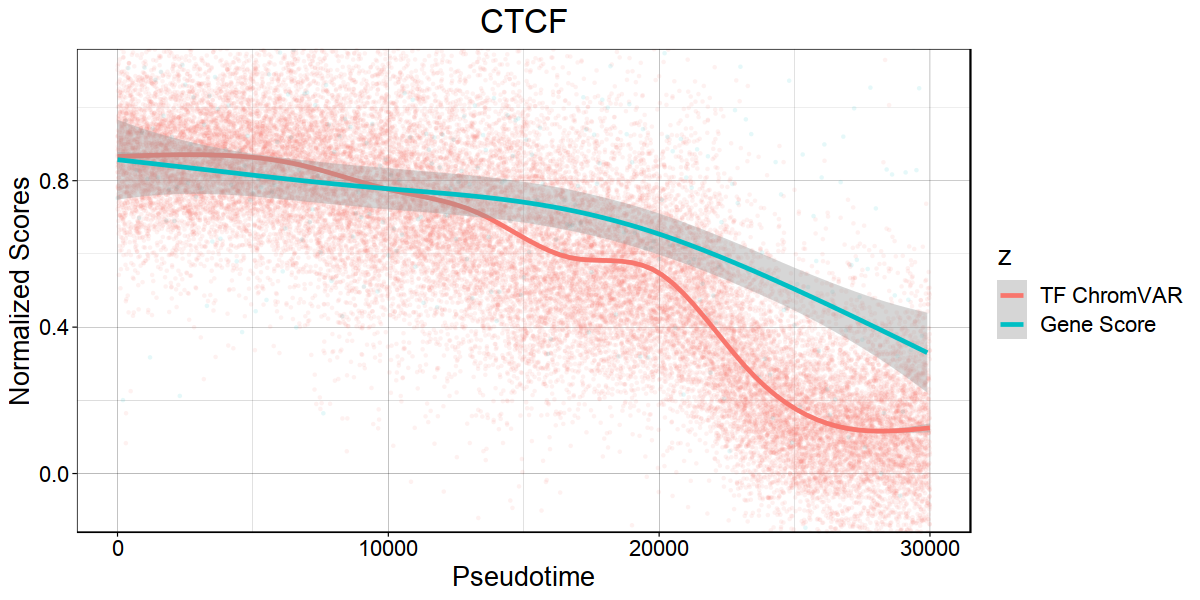

In [478]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(plot_df) + 
geom_point(aes(x=x,y=y,colour=z,group=z), stroke=0, size=1, alpha=0.1) +
geom_smooth(aes(x=x,y=y,colour=z, group=z)) +
xlab("Pseudotime") +
ylab("Normalized Scores") +
ggtitle("CTCF") +
coord_cartesian(ylim=c(-0.1,1.1)) +
theme_linedraw() +
theme(plot.title = element_text(hjust = 0.5),
     text = element_text(size=16))

### Peak Sets

In [147]:
cts_to_cluster = log2(1+(200*norm_cts/width(GRanges(rownames(cts_to_cluster)))))
# cts_to_cluster = t(scale(t(cts_to_cluster)))

In [68]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(cts_to_cluster, 
                        batch_size = 1000,
                        clusters=30,
                        num_init = 10, 
                        verbose = FALSE)

In [69]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)
# distance    = dist(km_mb$centroids)
distance    = dist(t(scale(t(km_mb$centroids))))
cluster     = hclust(distance, method="ward")
dendrogram  = as.dendrogram(cluster)
rowInd = rev(order.dendrogram(dendrogram))
pr_mb = order(rowInd)[pr_mb]

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



In [70]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10    11    12    13 
 4848     2    15     5    22 18847 26871 30067  7991  9880 19689 45231  8543 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
 9667  9458  3581 30673  9890  8923  6198 16391 13209  5780  6023  9163 37973 
   27    28    29    30 
27362 19039  8263 12372 

In [71]:
cts_clustered = cts_to_cluster[order(pr_mb),]
head(cts_clustered, 2)

[,1]      [,2]      [,3]      [,4]      [,5]     [,6]     
chr1:1205968-1206852 -1.247275 0.4872243 1.3836772 0.7606356 1.015099 0.9330105
chr1:1631816-1632369  2.214903 1.0359240 0.8182965 1.1724930 1.037704 0.4360084
                     [,7]      [,8]        [,9]       [,10]     [,11]
chr1:1205968-1206852 0.8191468 -0.03827285 -0.1174619 0.4564411 ⋯    
chr1:1631816-1632369 0.9088490  0.65651881  0.7871097 1.0750957 ⋯    
                     [,12]      [,13]     [,14]       [,15]     [,16]   
chr1:1205968-1206852 -0.5154414 0.6976378  0.02407523 0.7816758 2.024342
chr1:1631816-1632369  1.1951497 0.3864946 -1.09434608 1.7858036 1.343273
                     [,17]      [,18]     [,19]     [,20]    [,21]   
chr1:1205968-1206852  0.8225594 -2.221520 2.2765375 2.104988 -0.70067
chr1:1631816-1632369 -0.1522580  1.014856 0.8384845 1.510984  1.81320

5%       95% 
-1.479534  1.601706

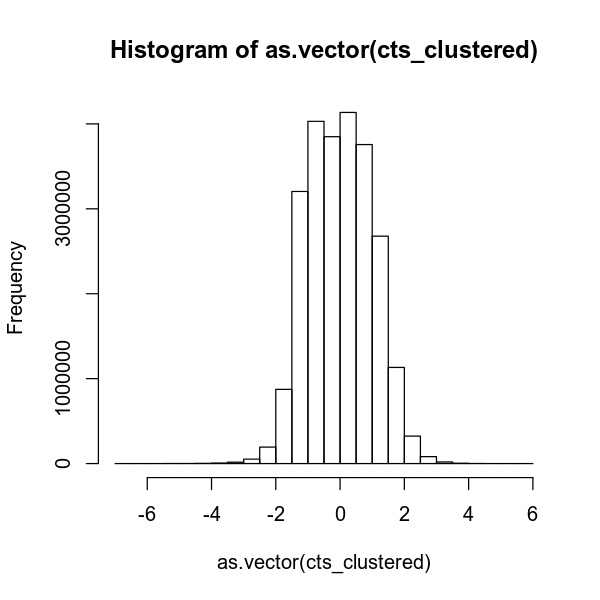

In [73]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(as.vector(cts_clustered))
quantile(as.vector(cts_clustered), c(0.05, 0.95))

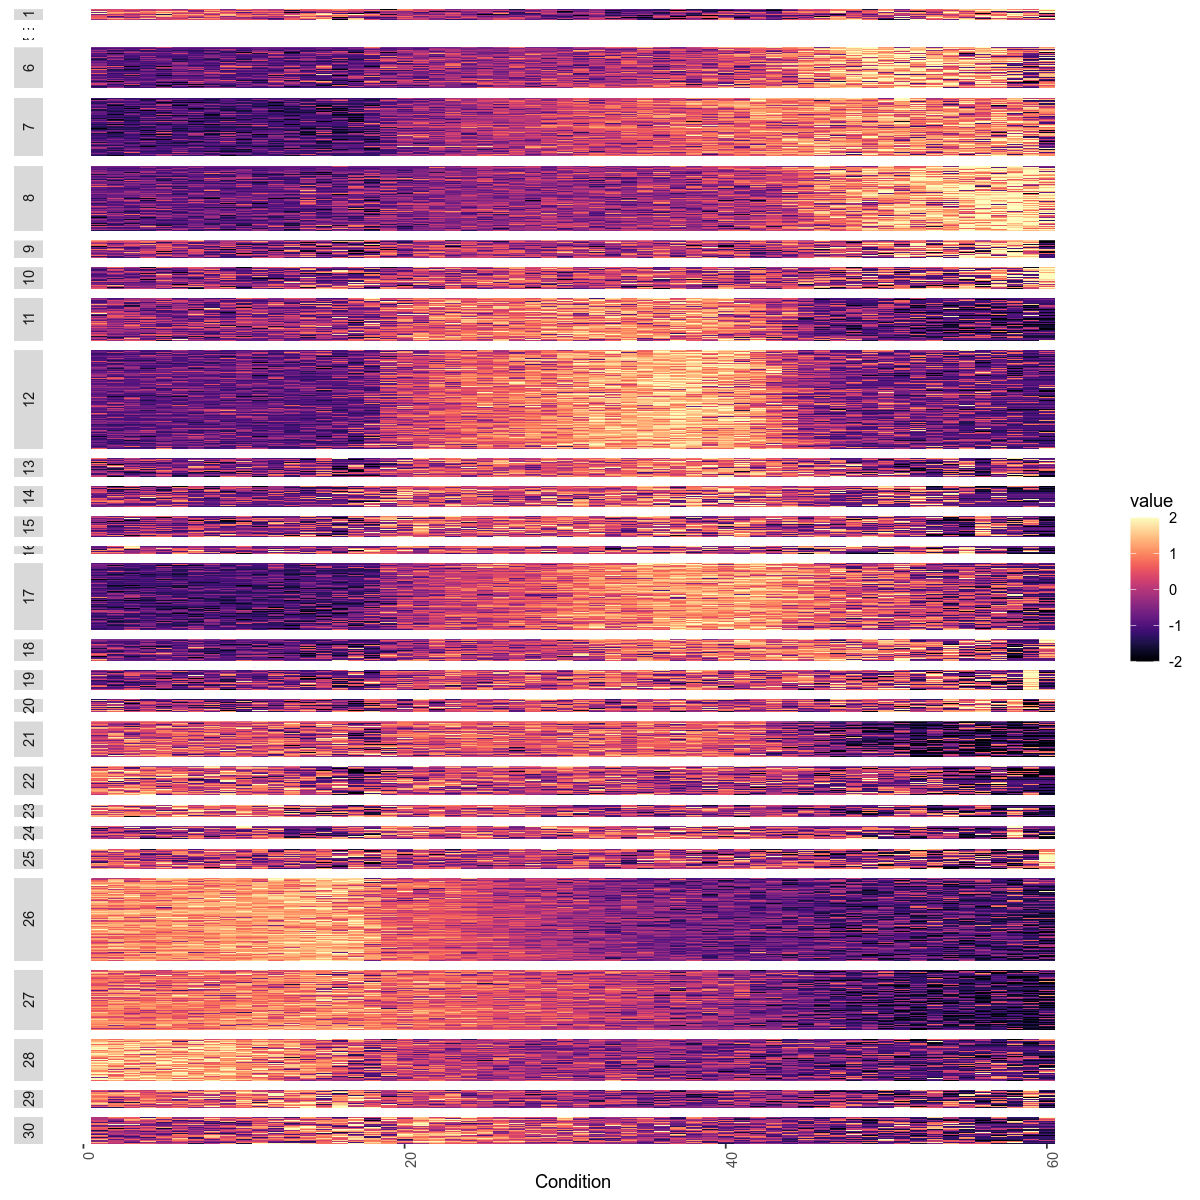

In [75]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 10) # if subsample
ggplot(data = melt(cts_clustered[idxs,]), mapping = aes(x = Var2,
                                                        y = Var1,
                                                        fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(-2, 2), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y")+
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank())
#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_heatmap_idr_znorm_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

In [148]:
weighted_order = order(rowSums(t(t(cts_to_cluster)*seq(1,60)))/rowSums(cts_to_cluster))
# weighted_order = order(rowSums(t(t(cts_to_cluster))*seq(1,60))))

In [149]:
mat_to_plot = cts_to_cluster[weighted_order, ]
colnames(mat_to_plot) = seq(ncol(mat_to_plot))
idxs = seq(1, nrow(mat_to_plot), 50)
mat_to_plot = mat_to_plot[idxs, ]
melted = melt(mat_to_plot)
melted$Var1 = factor(melted$Var1, levels=rownames(mat_to_plot))
melted$Var2 = factor(melted$Var2, levels=colnames(mat_to_plot))

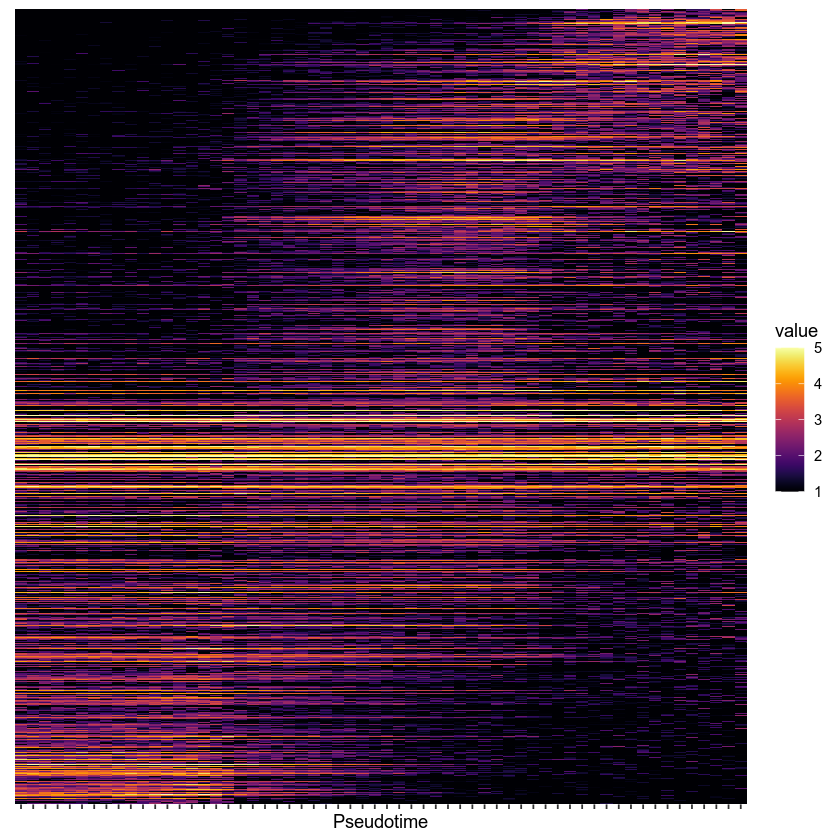

In [152]:
options(repr.plot.width = 7, repr.plot.height = 7)

ggplot(data = melted, mapping = aes(x = Var2,
                                    y = Var1,
                                    fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Pseudotime") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(1, 5), oob=squish, option = "B") +
theme(axis.text.x=element_blank(),
#       axis.text.y=element_text(angle=0,hjust=1, size=8),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank())

#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3)) 
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_pluripotency_pseudotime_chromvar.jpeg", format(Sys.Date(), format='%Y%m%d')),
#        width = 15, height = 5, dpi=300)

## Plot Raw Peaks

In [37]:
x.sp.path = x.sp[paste(x.sp@sample, x.sp@barcode, sep='_') %in% rownames(cells_in_path), ]

# sort by pseudotime
x.sp.path = x.sp.path[order(cells_in_path[paste(x.sp.path@sample, x.sp.path@barcode, sep='_'), "dpt_pseudotime"]),]

In [38]:
# check orders are the same
all(paste(x.sp.path@sample, x.sp.path@barcode, sep='_')==rownames(cells_in_path))

[1] TRUE

In [590]:
# choose peaks with sufficient counts, but not too high
peak_frac = Matrix::colMeans(x.sp.path@pmat)
q = quantile(peak_frac[peak_frac>0], c(0.3,0.8))

In [591]:
q*100

30%  80% 
0.36 2.34

In [592]:
x.sp.path = x.sp.path[, (peak_frac>q[1])&(peak_frac<q[2]), "pmat"]

In [593]:
x.sp.path

number of barcodes: 5000
number of bins: 0
number of genes: 0
number of peaks: 226159
number of motifs: 0

In [741]:
PEAKS_TO_SAMPLE = 100000
peak_mat = x.sp.path@pmat[, sample(ncol(x.sp.path@pmat), PEAKS_TO_SAMPLE)]

In [742]:
# extend each peak EXTEND steps in pseudotime
EXTEND = 10
extend_peaks <- function(x) {
    mileage = 0
    for (i in seq(length(x))) {
        if (x[i]>0) {
            mileage = EXTEND
        }
        else {
            if (mileage>0) {
                x[i] = 1
                mileage = mileage - 1
            }
        }
    }
    
    x
}

In [743]:
# shuffling for NULL (don't do as part of normal routine)
# peak_mat = peak_mat[sample(nrow(peak_mat)), ]

In [744]:
# choose peaks that aren't spread too much
# pt_vars = apply(peak_mat, 2, function (x) {var(which(x>0))})
# peak_mat = as.matrix(peak_mat[, pt_vars < quantile(pt_vars, 0.1)])

In [745]:
# sort by median
# peak_mat_row_ordered = as.matrix(t(peak_mat[,order(apply(peak_mat, 2, function (x) {median(which(x>0))}))]))
# colnames(peak_mat_row_ordered) = rownames(cells_in_path)

In [747]:
# first densify in pseudotime 
peak_mat = t(as.matrix(peak_mat))

# ENSURE second arg of create_sum_matrix is a divisor of the first
peak_mat_to_cluster = as.matrix(peak_mat) %*% create_sum_matrix(ncol(peak_mat), 50)

# binarize it
# peak_mat_to_cluster = as.matrix((peak_mat_to_cluster>0)+0)

km_mb = MiniBatchKmeans(peak_mat_to_cluster, 
                        batch_size = 1000,
                        clusters=10,
                        num_init = 10, 
                        verbose = FALSE)

In [857]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(peak_mat_to_cluster, km_mb$centroids)

# use hierarchical clustering on median
# distance    = dist(t(scale(t(km_mb$centroids))))
# cluster     = hclust(distance, method="ward")
# dendrogram  = as.dendrogram(cluster)
# rowInd = rev(order.dendrogram(dendrogram))

# sort by weighted position median -- not sure if this works
rowInd = order(apply(t(scale(t(km_mb$centroids))), 1, function (x) {mean(which(x>0))}))

pr_mb = order(rowInd)[pr_mb]

In [858]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10 
 8925 18604     2  6422 35577  2539  7681  1377 13282  5591 

In [863]:
peak_mat_row_ordered = peak_mat[order(pr_mb),]
# peak_mat_row_ordered = km_mb$centroids[rowInd,]
# colnames(peak_mat_row_ordered) = rownames(cells_in_path)
colnames(peak_mat_row_ordered) = seq(1, ncol(peak_mat_row_ordered))
head(peak_mat_row_ordered, 2)

1 2 3 4 5 6 7 8 9 10 ⋯ 4991 4992 4993 4994 4995 4996 4997 4998 4999 5000
[1,] 0 1 0 0 0 0 0 0 0 0  ⋯ 0    0    0    0    0    0    0    0    0    0   
[2,] 0 0 0 0 0 0 0 0 0 0  ⋯ 0    0    0    0    0    0    0    0    0    0

In [867]:
# subsample for speed 
peak_mat_to_plot = peak_mat_row_ordered[seq(1,nrow(peak_mat_row_ordered), 500), seq(1,ncol(peak_mat_row_ordered), 1)]

# extend for better viewing
peak_mat_to_plot = t(apply(peak_mat_to_plot, 1, extend_peaks))

melted = melt(peak_mat_to_plot)
# melted$Var1 = factor(melted$Var1, levels=rownames(peak_mat_to_plot))
melted$Var2 = factor(melted$Var2, levels=colnames(peak_mat_to_plot))

In [868]:
head(melted, 2)

Var1 Var2 value
1 1    1    0    
2 2    1    0

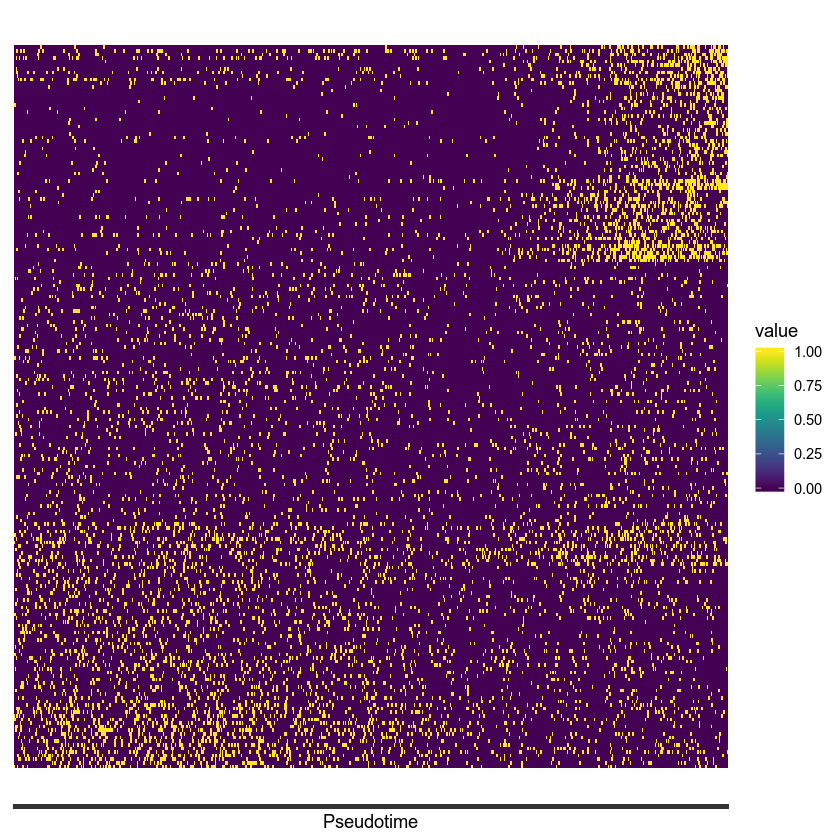

In [869]:
options(repr.plot.width = 7, repr.plot.height = 7)

ggplot(data = melted, mapping = aes(x = Var2,
                                    y = Var1,
                                    fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Pseudotime") +  
geom_raster(aes(fill=value)) +
# scale_fill_viridis(limits=c(-1, 1), oob=squish, option = "B") +
# scale_fill_gradient(limits=c(0, 1), oob=squish, low="dodgerblue4", high="khaki1") +
scale_fill_viridis(limits=c(0,1), oob=squish, option='D') +
# facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
# theme_classic() +
theme(axis.text.x=element_blank(),
#       axis.text.y=element_text(angle=0,hjust=1, size=8),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank())

#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3)) 
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_pluripotency_pseudotime_chromvar.jpeg", format(Sys.Date(), format='%Y%m%d')),
#        width = 15, height = 5, dpi=300)